In [2]:
from keras import Input, layers
from keras.models import Model
import tensorflow as tf
import keras.backend as K
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [ ]:
img_path = 'sky.jpeg'
weight_path = 'vgg19_weights_tf_dim_ordering_tf_kernels.h5'

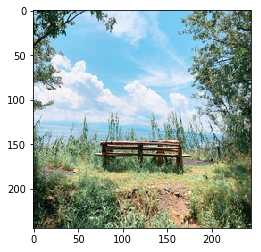

In [3]:
img=mpimg.imread(img_path)
imgplot = plt.imshow(img)
img = img/255.0 - 0.5

In [18]:
K.clear_session()

class AddReconLayer(layers.Layer):
    '''
        white noise가 content reconstruction이 되도록 특정한 값이 더해주는 레이어
    '''

    def __init__(self, **kwargs):
        super(AddReconLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=input_shape[1:],
            initializer='uniform',
            trainable=True)
        super(AddReconLayer, self).build(input_shape)

    def call(self, x):
        return tf.multiply(x, self.kernel)

    def compute_output_shape(self, input_shape):
        return input_shape

    
class ContentRecon:
    '''
        Figure 1: Convolution Neurla Network(CNN)의 Content Reconstructions를 재현하기 위한 class
    '''
    
    def __init__(self, img, level, weight_path,show_summary=False):
        
        self.img = img
        self.input_img_size = self.img.shape
        self.ones = np.ones(shape=self.input_img_size, dtype='float32')
        self.weight_path = weight_path
        
        # input
        img_input = Input(shape=self.input_img_size, name='img')
        white_noise_input = Input(shape=self.input_img_size, name='ones')
        
        self.recon_layer = AddReconLayer()
        rec_img = self.recon_layer(white_noise_input)
        
        # cnn blocks
        f, p = self._make_cnn_layers(level, (img_input, rec_img))
        x = layers.Subtract()([f, p])
        x = layers.Lambda(lambda x: tf.divide(tf.reduce_sum(tf.square(x)), 2.0), output_shape=(1,1))(x)
        
        self.model = Model([img_input, white_noise_input], x)
        self._set_weights()
        self.output_shape = tuple(x.shape.as_list()[1:])
        
        if show_summary:
            self.model.summary()
        
        self.model.compile(
            optimizer='rmsprop',
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])        
    
    def _make_cnn_layers(self, level, input_layers):
        
        img_input, rec_img = input_layers
        
        # Block classes
        
        # Block 1
        block1_conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', trainable=False)
        block1_conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', trainable=False)
        block1_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block1_pool')
        
        # Block 2
        block2_conv1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', trainable=False)
        block2_conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', trainable=False)
        block2_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block2_pool')
        
        # Block 3
        block3_conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', trainable=False)
        block3_conv2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', trainable=False)
        block3_conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', trainable=False)
        block3_conv4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4', trainable=False)
        block3_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block3_pool')
        
        # Block 4
        block4_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', trainable=False)
        block4_conv2 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', trainable=False)
        block4_conv3 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', trainable=False)
        block4_conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4', trainable=False)
        block4_pool = layers.AveragePooling2D((2, 2), strides=(2, 2), name='block4_pool')
        
        # Block 5
        block5_conv1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')
        
        if level >= 1:
            f, p = block1_conv1(img_input), block1_conv1(rec_img)
            
        if level >= 2:
            f, p = block1_conv2(f), block1_conv2(p)
            f, p = block1_pool(f), block1_pool(p)
            
            f, p = block2_conv1(f), block2_conv1(p)
            
        if level >= 3:
            f, p = block2_conv2(f), block2_conv2(p)
            f, p = block2_pool(f), block2_pool(p)
            
            f, p = block3_conv1(f), block3_conv1(p)
            
        if level >= 4:
            f, p = block3_conv2(f), block3_conv2(p)
            f, p = block3_conv3(f), block3_conv3(p)
            f, p = block3_conv4(f), block3_conv4(p)
            f, p = block3_pool(f), block3_pool(p)

            f, p = block4_conv1(f), block4_conv1(p)
            
        if level == 5:
            f, p = block4_conv2(f), block4_conv2(p)
            f, p = block4_conv3(f), block4_conv3(p)
            f, p = block4_conv4(f), block4_conv4(p)
            f, p = block4_pool(f), block4_pool(p)

            f, p = block5_conv1(f), block5_conv1(p)
        
        return f, p
        
    def _set_weights(self):
        with h5py.File(self.weight_path, 'r') as f:
            for l in self.model.layers:
                if l.name in list(f.keys()) and 'conv' in l.name:
                    w, b = list(f[l.name])
                    w, b = f[l.name][w][:], f[l.name][b][:]
                    l.set_weights([w, b])
    
    def fit(self, epoch=500):
        for i in range(epoch):
            verbose = 0
            if i % 100 == 0:
                print(i)
                verbose = 2
                self.show_img()
                
            self.model.fit(
                {'img': np.asarray([self.img]), 'ones': np.asarray([self.ones])},
                np.zeros((1, 1, 1), dtype='float32'),
                epochs=1,
                batch_size=1,
                verbose=verbose)
        self.show_img()
        
    def show_img(self):
        rec_img = np.clip((K.eval(self.recon_layer.kernel)+0.5)*255, 0, 255).astype('int')
        plt.imshow(rec_img)
        plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ones (InputLayer)               (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
img (InputLayer)                (None, 244, 244, 3)  0                                            
__________________________________________________________________________________________________
add_recon_layer_1 (AddReconLaye (None, 244, 244, 3)  178608      ones[0][0]                       
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 244, 244, 64) 1792        img[0][0]                        
                                                                 add_recon_layer_1[0][0]          
__________

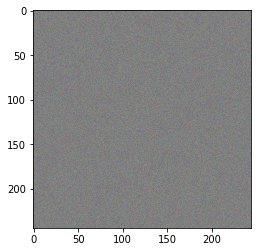

Epoch 1/1
 - 0s - loss: 134504.1562 - mean_absolute_error: 134504.1562
100


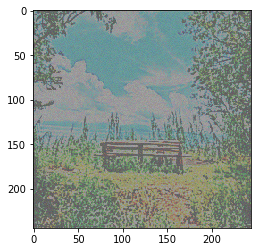

Epoch 1/1
 - 0s - loss: 50239.8984 - mean_absolute_error: 50239.8984
200


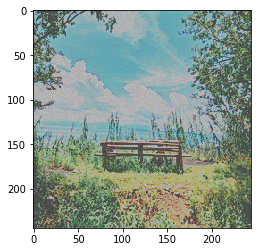

Epoch 1/1
 - 0s - loss: 19451.5840 - mean_absolute_error: 19451.5840
300


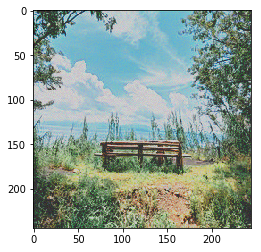

Epoch 1/1
 - 0s - loss: 5941.9004 - mean_absolute_error: 5941.9004
400


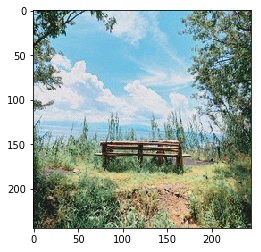

Epoch 1/1
 - 0s - loss: 911.5265 - mean_absolute_error: 911.5265
500


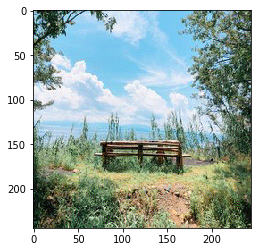

Epoch 1/1
 - 0s - loss: 23.6140 - mean_absolute_error: 23.6140
600


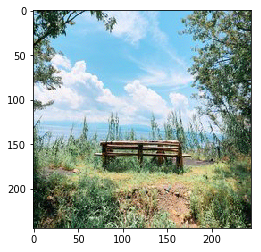

Epoch 1/1
 - 0s - loss: 7.3918 - mean_absolute_error: 7.3918
700


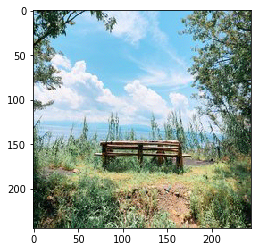

Epoch 1/1
 - 0s - loss: 5.3238 - mean_absolute_error: 5.3238
800


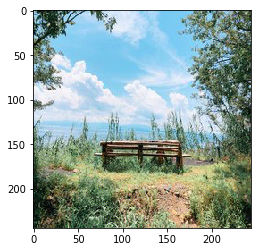

Epoch 1/1
 - 0s - loss: 4.4559 - mean_absolute_error: 4.4559
900


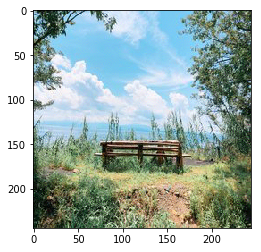

Epoch 1/1
 - 0s - loss: 3.9897 - mean_absolute_error: 3.9897


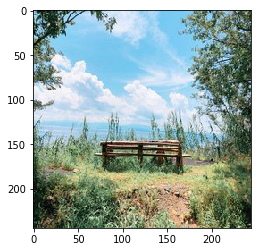

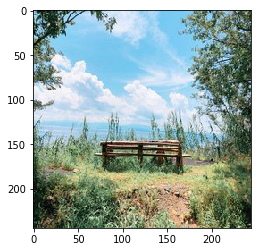

In [17]:
con = ContentRecon(img, 1, weight_path)
con.fit(1000)
con.show_img()